In [1]:
using StateSpaceDynamics

In [2]:
using StateSpaceDynamics: initialize_slds
using StateSpaceDynamics: sample

In [3]:
true_ssm = initialize_slds()

SwitchingLinearDynamicalSystem([0.5686413682169027 0.4313586317830972; 0.39042143546215796 0.6095785645378421], StateSpaceDynamics.LinearDynamicalSystem[StateSpaceDynamics.LinearDynamicalSystem{StateSpaceDynamics.GaussianStateModel{Float64}, StateSpaceDynamics.GaussianObservationModel{Float64}}(StateSpaceDynamics.GaussianStateModel{Float64}([0.9204668006251124 -0.2350337612917968; 0.2350337612917968 0.9204668006251124], [0.1 0.0; 0.0 0.1], [0.0, 0.0], [0.1 0.0; 0.0 0.1]), StateSpaceDynamics.GaussianObservationModel{Float64}([-0.8595553820616212 -1.6658075498442124; -1.4692882055065464 0.38163694535441856; … ; 0.517130881450359 1.1979596698125403; 1.4472238915818758 -1.2290887130815225], [0.5 0.0 … 0.0 0.0; 0.0 0.5 … 0.0 0.0; … ; 0.0 0.0 … 0.5 0.0; 0.0 0.0 … 0.0 0.5]), 2, 10, Bool[1, 1, 1, 1, 1, 1]), StateSpaceDynamics.LinearDynamicalSystem{StateSpaceDynamics.GaussianStateModel{Float64}, StateSpaceDynamics.GaussianObservationModel{Float64}}(StateSpaceDynamics.GaussianStateModel{Float64}

In [5]:
T = 100
# Generate synthetic data
_, observations, true_latent = sample(true_ssm, T)


([-0.4044574416566668 -0.24989952299390197 … 1.2267950123065707 1.2835956370194734; -0.2652718558318045 -0.14298430182857694 … -0.42755117386382896 -0.12345107738656991], [0.9866166462828636 -0.3255434918225606 … 1.0122379672743689 -0.7463233328721162; 0.2596981458488341 0.17882823758802188 … -2.3616025947414063 -2.3170097573682553; … ; -1.1471560092825692 -0.5695142744363186 … -1.279316328257166 0.4287518277379492; 0.03471289430441671 -1.2405777285598338 … 2.870723611056925 2.20190786391735], [1, 1, 2, 2, 1, 2, 2, 2, 2, 1  …  1, 2, 2, 2, 2, 2, 1, 2, 2, 2])

In [6]:
using Plots

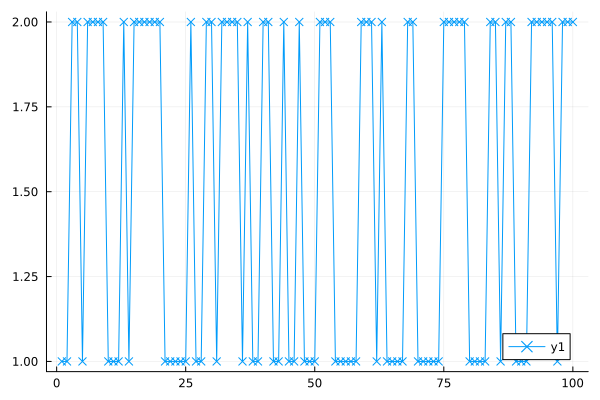

In [11]:
plot(true_latent, marker=:x)

In [5]:
using StateSpaceDynamics: variational_expectation

In [13]:
true_ssm.B[1]

StateSpaceDynamics.LinearDynamicalSystem{StateSpaceDynamics.GaussianStateModel{Float64}, StateSpaceDynamics.GaussianObservationModel{Float64}}(StateSpaceDynamics.GaussianStateModel{Float64}([0.9204668006251124 -0.2350337612917968; 0.2350337612917968 0.9204668006251124], [0.1 0.0; 0.0 0.1], [0.0, 0.0], [0.1 0.0; 0.0 0.1]), StateSpaceDynamics.GaussianObservationModel{Float64}([-0.8595553820616212 -1.6658075498442124; -1.4692882055065464 0.38163694535441856; … ; 0.517130881450359 1.1979596698125403; 1.4472238915818758 -1.2290887130815225], [0.5 0.0 … 0.0 0.0; 0.0 0.5 … 0.0 0.0; … ; 0.0 0.0 … 0.5 0.0; 0.0 0.0 … 0.0 0.5]), 2, 10, Bool[1, 1, 1, 1, 1, 1])

In [14]:
# smooth observations using the naive model
smoothed_x, smoothed_p, _ = smooth(true_ssm.B[1], observations)

([-0.49858874711162604 -0.27833182274841634 … 1.310463441739099 1.4844275602986183; -0.28474556200038204 -0.0031466658879005707 … -0.7633435306379693 -0.23315833461543542], [0.02584786057682093 -0.000772272269630489; -0.000772272269630489 0.030017582930369182;;; 0.02745175098140197 -0.0009989971257369707; -0.0009989971257369707 0.03241619970210085;;; 0.027559472122560512 -0.0010341527918415058; -0.0010341527918415058 0.032600185198925595;;; … ;;; 0.027590650713342324 -0.0010377526328384295; -0.0010377526328384295 0.032670693842863086;;; 0.02793888493859371 -0.0010734751986067083; -0.0010734751986067083 0.03331306178667164;;; 0.033832829463928814 -0.001644364618177169; -0.001644364618177169 0.04107628408502342], [0.0 0.0; 0.0 0.0;;; 0.0061552379024149475 -0.0022193224556628396; 0.0014250823445056597 0.008299404458570933;;; 0.006549311332050077 -0.002435622961737791; 0.0014637818406161211 0.008952116432752332;;; … ;;; 0.006584938172269613 -0.0024599810534247217; 0.0014632973953307875 0.0

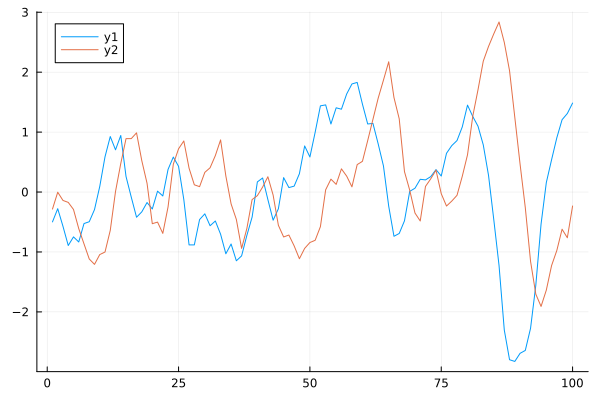

In [17]:
plot(smoothed_x')

In [15]:
size(observations)

(10, 100)

In [ ]:
num_obs = size(transpose_data[1], 1)
# initialize forward backward storage
FB_storage = initialize_forward_backward(model, num_obs)
emission_loglikelihoods!(model, FB_storage, data...)
forward!(model, FB_storage)
backward!(model, FB_storage)
calculate_γ!(model, FB_storage)

In [ ]:
function update_q_z_with_samples(model::SLDS, y::Matrix{Float64}, x_samples::Matrix{Float64})
    T = size(y, 2)  # Number of time steps
    K = size(model.A, 1)  # Number of discrete states
    num_samples = size(x_samples, 3)  # Number of samples from q(x)

    # Log-transformed quantities for numerical stability
    log_pi = log.(model.pi)
    log_A = log.(model.A)
    log_likelihoods = zeros(Float64, K, T, num_samples)

    num_obs = size(transpose_data[1], 1)
    # initialize forward backward storage
    FB_storage = initialize_forward_backward(model, num_obs)
    emission_loglikelihoods!(model, FB_storage, data...)
    forward!(model, FB_storage)
    backward!(model, FB_storage)
    calculate_γ!(model, FB_storage)

    # Compute log-likelihoods for each discrete state given samples of x
    for s in 1:num_samples
        for k in 1:K
            for t in 1:T
                residual = y[:, t] - model.C * x_samples[:, t, s]
                log_likelihoods[k, t, s] = -0.5 * residual' * inv(model.R) * residual
                log_likelihoods[k, t, s] -= 0.5 * logdet(2π * model.R)
            end
        end
    end

    # Average log-likelihoods over samples
    mean_log_likelihoods = mean(log_likelihoods; dims=3)

    # Use the forward-backward algorithm to compute q(z)
    α = zeros(Float64, K, T)
    β = zeros(Float64, K, T)

    # Forward pass
    α[:, 1] .= log_pi + mean_log_likelihoods[:, 1]
    for t in 2:T
        for k in 1:K
            α[k, t] = logsumexp(α[:, t - 1] .+ log_A[:, k]) + mean_log_likelihoods[k, t]
        end
    end

    # Backward pass
    β[:, T] .= 0.0
    for t in (T - 1):-1:1
        for k in 1:K
            β[k, t] = logsumexp(log_A[k, :] .+ mean_log_likelihoods[:, t + 1] .+ β[:, t + 1])
        end
    end

    # Compute q(z) (normalized log probabilities)
    log_q_z = α .+ β
    log_q_z .= log_q_z .- logsumexp(log_q_z; dims=1)  # Normalize across states
    return exp.(log_q_z)
end


In [ ]:
loglikelihood(model::HiddenMarkovModel, data...)

In [6]:
variational_expectation(true_ssm, observations)

([0.8023279156643639 0.5334122626391126 … 0.47509236476244066 0.47509236476244066; 0.1976720843355993 0.4665877373609078 … 0.5249076352376105 0.5249076352376105], [0.0475711321096286 0.00012569094083022828 … 0.0 0.0; 0.01172025135200156 0.0001099447009309059 … 0.0 0.0], [0.0 0.0 … 6.31109390544976e-5 1.0; 0.0 0.0 … 6.31109390544976e-5 1.0], [0.0 0.023470562043173 … -0.1554613767447383 -0.6344428090760141; 0.0 -0.716040365559033 … 0.48841406528176157 -0.43557054322960187], [[0.0 0.0; 0.0 0.0], [0.036732071707220065 -0.00168934352555068; -0.0016893435255506853 0.04494057048068317], [0.03400855997029205 -0.0016736227122747544; -0.001673622712274735 0.041383282177555034], [0.033844781568166775 -0.0016491464731779064; -0.0016491464731778873 0.04109989501888038], [0.03383374247503284 -0.00164491217396432; -0.0016449121739643105 0.041078002859776606], [0.03383290453303239 -0.0016444160395558166; -0.0016444160395558283 0.04107640209722005], [0.033832835733116205 -0.0016443688051182455; -0.0016

In [ ]:
fit_slds!(slds, observations)